# 遗传算法 Genetic Algorithm

xyfJASON

## 1 概述

遗传算法是一种模拟自然选择和自然遗传机制的优化算法。在算法中，我们称一个可行解为一个**个体**，许多可行解构成一个**种群**。我们需要将每个可行解（即每个个体）**编码**成一个向量，而向量也能被**解码**称一个可行解，称这个向量为**染色体**。也就是说，这个向量中的每个数就好比染色体上的碱基对。众所周知，染色体可以**交叉互换**，其上的碱基对也可以发生**变异**，在遗传算法中，交叉互换的意义在于产生更优解，而变异的意义在于跳出局部最优解。

综上，遗传算法的步骤如下：

1. 设定种群大小、进化的代数、交叉互换率、变异率
2. 确定编码解码规则，设定适应度函数，设定初始种群
3. 当前种群进行交叉互换和变异
4. 按照适者生存机制选择新一代种群，即适应度越高，有越大概率被选中
5. 重复 3、4 步直至达到进化代数

## 2 代码模板

见同文件夹下的 `modopt.py` 模块。

## 3 例题

### 3.1 例一——旅行商问题 (TSP)

http://www.math.uwaterloo.ca/tsp/vlsi/index.html

遗传算法解 TSP 问题：

- 设定编码规则为：将访问的城市编号顺序列出，即作为编码向量
- 设定适应度函数：由于距离越短说明结果越好，我将适应度设置为距离的相反数，随后对种群进行了归一化；也有其他多种定义方式
- 设定交叉互换规则：PMX 等
- 设定变异规则：任选两位置，翻转中间的城市序号

遗传算法似乎不是很擅长解决 TSP 问题（也可能是我的打开方式不太对），下面的代码仅求解 30 个点，当点数较大时，遗传算法得到的解的质量很差。

读入数据文件，准备工作：

In [1]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'
import numpy as np

with open('data/tsp_data.txt') as f:
    data = [list(map(int, line.strip().split())) for line in f.readlines()]
    data = np.array(data)
n = 30

def distance(_i, _j):
    """ distance between the ith row and the jth row """
    return np.sqrt((data[_i, 1] - data[_j, 1]) ** 2 + (data[_i, 2] - data[_j, 2]) ** 2)

def evaluate(state: np.ndarray) -> float:
    assert len(state.shape) == 1
    dist = 0.0
    for i in range(state.shape[0]):
        j = (i + 1) % state.shape[0]
        dist += distance(state[i], state[j])
    return dist

继承 `GeneticAlgorithm` 类，重写方法，包括：生成初始编码、设定适应度函数、设定变异规则、设定交叉互换规则

In [2]:
from modopt import GeneticAlgorithm

class Solver(GeneticAlgorithm):
    def gen_init_population_code(self) -> np.ndarray:
        states = []
        for k in range(self.sz_population):
            best_init_state, best_init_dist = np.arange(n), np.inf
            for _ in range(10):
                init_state = np.random.permutation(n)
                init_dist = evaluate(init_state)
                if init_dist < best_init_dist:
                    best_init_state, best_init_dist = init_state, init_dist
            states.append(best_init_state)
        return np.array(states)

    def calc_fitness(self, population_code) -> np.ndarray:
        assert len(population_code.shape) == 2
        dists = np.array([evaluate(pop) for pop in population_code])
        fitness = (np.max(dists) - dists) / (np.max(dists) - np.min(dists) + 1e-6)
        return fitness

    def mutate(self, code: np.ndarray) -> np.ndarray:
        assert len(code.shape) == 1
        u, v = np.random.choice(code.shape[0]+1, 2, replace=False)
        u, v = (v, u) if u > v else (u, v)
        mutate_code = code.copy()
        mutate_code[u:v] = mutate_code[u:v][::-1]  # [u, v)
        return mutate_code

    def crossover(self, code1: np.ndarray, code2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """ PMX """
        assert len(code1.shape) == len(code2.shape) == 1
        assert code1.shape[0] == code2.shape[0]
        u, v = np.random.choice(code1.shape[0]+1, size=2, replace=False)
        u, v = (v, u) if u > v else (u, v)
        result1, result2 = code1.copy(), code2.copy()
        result1[u:v] = code2[u:v]; result2[u:v] = code1[u:v]
        while True:
            ok = True
            for i in range(code1.shape[0]):
                if u <= i < v:
                    continue
                if result1[i] in code2[u:v].tolist():
                    result1[i] = code1[np.where(code2 == result1[i])[0]]
                    ok = False
                if result2[i] in code1[u:v].tolist():
                    result2[i] = code2[np.where(code1 == result2[i])[0]]
                    ok = False
            if ok:
                break
        return result1, result2

设定种群大小 $50$，遗传代数 $1000$，交叉互换率为 $1$，变异率为 $0.1$，运行遗传算法：

In [3]:
solver = Solver(sz_population=50,
                n_generations=1000,
                rate_cross=1,
                rate_mutate=0.1)
res = solver.run()
res = res[0][res[1].argmax()]

res
evaluate(res)

100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.33it/s]


array([20, 21, 22, 23, 10,  9,  3,  8,  1,  2,  7,  6, 29, 28, 27, 25, 24,
       17, 12,  4, 11,  0,  5, 13, 14, 18, 26, 16, 15, 19])

169.16686935618628

绘制路线图：

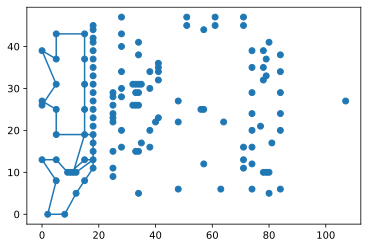

In [4]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

def plot_route(res_state):
    fig, ax = plt.subplots(1, 1)
    ax.scatter(data[:, 1], data[:, 2])
    ax.plot(np.hstack((data[res_state, 1], data[res_state[0:1], 1])),
            np.hstack((data[res_state, 2], data[res_state[0:1], 2])))
    plt.show()

plot_route(res)

### 3.2 例二

求下列函数在 $[-3,3]^2$ 上的最大值：
$$
F(x,y)=3(1-x)^2e^{-x^2-(y+1)^2}-10\left(\frac{x}{5}-x^3-y^5\right)e^{-x^2-y^2}-\frac{1}{3}^{\exp\left(-(x+1)^2-y^2\right)}
$$

- 设定编码规则为：将数字缩放到 $[0,1]$ 区间中，表示为二进制小数，随后取小数点后 24 位构成 01 向量作为编码
- 设定适应度函数：函数值减去最小函数值
- 设定交叉互换规则：从某一位置后互换
- 设定变异规则：随机改变 01 向量的某一位（0 变 1，1 变 0）

代码如下：

In [5]:
def F(x, y):
    return 3*(1-x)**2*np.exp(-(x**2)-(y+1)**2)-10*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1/3**np.exp(-(x+1)**2-y**2)

def decoder(code: np.ndarray) -> tuple[float, float]:
    x, y = 0, 0
    for i in range(24):
        x = x * 2 + code[i]
    for i in range(24, 48):
        y = y * 2 + code[i]
    x /= (1 << 24); y /= (1 << 24)
    return x * 6 - 3, y * 6 - 3

class Solver(GeneticAlgorithm):
    def gen_init_population_code(self) -> np.ndarray:
        return np.vstack(np.random.randint(0, 2, (self.sz_population, 48)))

    def calc_fitness(self, population_code: np.ndarray) -> np.ndarray:
        fitness = np.array([F(*decoder(code)) for code in population_code])
        return fitness - np.min(fitness) + 1e-6

    def mutate(self, code: np.ndarray) -> np.ndarray:
        pos = np.random.randint(0, 44)
        newcode = code.copy()
        newcode[pos] = 1 - newcode[pos]
        return newcode

solver = Solver(sz_population=50,
                n_generations=1000,
                rate_cross=0.95,
                rate_mutate=0.1)
res = solver.run()

decoder(res[0][res[1].argmax()])
F(*decoder(res[0][res[1].argmax()]))

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 282.58it/s]


(-0.020592570304870605, 1.4999817609786987)

7.054074472649538

作图如下：
![](img/ga.png)